# Determination of a promising tariff for a telecom company

Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department of the federal mobile operator wants to understand which tariff brings in more money.

**Aim:** Conduct tariff analysis on a sample of mobile operator's clients and identify a more promising tariff.

**Main areas of research:**

- Analyze what services are used
- Highlight services for which the user spends in excess of the monthly fee
- Test hypotheses about average revenue from users of different tariffs and different regions

**The study contains the following steps:**

- Data overview
- Data preprocessing
- Analysis
- Hypothesis testing
- Conclusions

## Data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0)
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')


## Data preprocessing

### сalls

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


<div style="background-color: #F2E0C9">

- 4 columns, no missing values
- Convert `call_date` to date format and select a separate month column
- In the `duration` column, round all values towards a larger integer and replace 0 with 1, since billing is by minutes.

</div>

In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [6]:
calls['month'] = calls['call_date'].astype('datetime64[M]')


In [7]:
calls['duration'] = np.ceil(calls['duration'])
calls.loc[calls['duration'] == 0, 'duration'] = 1
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,1.0,1000,2018-07-01
1,1000_1,2018-08-17,1.0,1000,2018-08-01
2,1000_2,2018-06-11,3.0,1000,2018-06-01
3,1000_3,2018-09-21,14.0,1000,2018-09-01
4,1000_4,2018-12-15,6.0,1000,2018-12-01


### internet

In [8]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


<div style="background-color: #F2E0C9">

- 5 columns, no missing values
- Convert `session_date` to date format and select a separate month column
- In the `mb_used` column, round all values towards a larger integer and replace 0 with 1, since billing is by Gb.

</div>

In [10]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month

In [11]:
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

### messages

In [12]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


<div style="background-color: #F2E0C9">

- 3 columns, no missing values
- Convert `message_date` to date format and select a separate month column

</div>

In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month

### users

In [15]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


<div style="background-color: #F2E0C9">

- 8 columns, There are missing values in churn_date
- Convert `churn_date` and `reg_date` to date format
- Replace smart - 1, ultra - 0 in `tariff`

</div>

In [17]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [18]:
def tariff_id(object):
    if object == 'smart':
        return 1
    elif object == 'ultra':
        return 0
users['tariff_id'] = users['tariff'].apply(tariff_id)

### tarrifs

In [19]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [20]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Feature engineering

For each user it is necessary to calculate:

- the number of calls made and spent minutes of conversation by month;
- the number of sent messages by month;
- volume of Internet traffic by months;
- monthly revenue from each user

In [21]:
calls_grouped = calls.pivot_table(values='duration',
                                  index=['user_id', 'month'],
                                  aggfunc=['count', 'sum'])
calls_grouped.columns = ['calls', 'duration']

calls_grouped

calls  duration
user_id month                      
1000    2018-05-01     22     164.0
        2018-06-01     43     187.0
        2018-07-01     47     346.0
        2018-08-01     52     418.0
        2018-09-01     58     478.0
...                   ...       ...
1498    2018-10-01     41     258.0
1499    2018-09-01      9      71.0
        2018-10-01     68     473.0
        2018-11-01     74     624.0
        2018-12-01     69     505.0

[3174 rows x 2 columns]

In [22]:
messages_grouped = messages.pivot_table(values='id',
                                  index=['user_id', 'month'],
                                  aggfunc='count')
messages_grouped.columns = ['messages']

messages_grouped

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

In [23]:
internet_grouped = internet.pivot_table(values='mb_used',
                                        index=['user_id', 'month'],
                                        aggfunc='sum')
internet_grouped.columns = ['mb']

internet_grouped

mb
user_id month          
1000    5       2254.49
        6      23238.77
        7      14004.64
        8      14057.93
        9      14570.91
...                 ...
1498    10     20589.36
1499    9       1846.75
        10     17803.51
        11     17973.31
        12     13060.58

[3203 rows x 1 columns]

In [24]:
total_df = users.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')
total_df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0,1000,30720,3000,1950,150,1,1,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1,50,15360,500,550,200,3,3,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1,50,15360,500,550,200,3,3,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,0,1000,30720,3000,1950,150,1,1,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,0,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,0,1000,30720,3000,1950,150,1,1,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,1,50,15360,500,550,200,3,3,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,1,50,15360,500,550,200,3,3,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,1,50,15360,500,550,200,3,3,smart


In [25]:
from functools import reduce

data_frames = [calls_grouped, messages_grouped, internet_grouped]
all_data = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],
                                            how='outer'), data_frames)

all_data

,calls,duration,messages,mb
user_id,,,,
1000,22.0,164.0,22.0,2254.49
1000,22.0,164.0,22.0,23238.77
1000,22.0,164.0,22.0,14004.64
1000,22.0,164.0,22.0,14057.93
1000,22.0,164.0,22.0,14570.91
...,...,...,...,...
1489,NaN,NaN,35.0,11056.56
1489,NaN,NaN,35.0,17220.30
1489,NaN,NaN,35.0,19570.44


In [26]:
all_data = pd.merge(all_data, total_df, on='user_id')
all_data

,user_id,calls,duration,messages,mb,age,churn_date,city,first_name,last_name,...,tariff,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,22.0,164.0,22.0,2254.49,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,0,1000,30720,3000,1950,150,1,1,ultra
1,1000,22.0,164.0,22.0,23238.77,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,0,1000,30720,3000,1950,150,1,1,ultra
2,1000,22.0,164.0,22.0,14004.64,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,0,1000,30720,3000,1950,150,1,1,ultra
3,1000,22.0,164.0,22.0,14057.93,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,0,1000,30720,3000,1950,150,1,1,ultra
4,1000,22.0,164.0,22.0,14570.91,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,0,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207172,1489,NaN,NaN,35.0,11056.56,35,NaT,Санкт-Петербург,Павел,Гончаров,...,smart,1,50,15360,500,550,200,3,3,smart
207173,1489,NaN,NaN,35.0,17220.30,35,NaT,Санкт-Петербург,Павел,Гончаров,...,smart,1,50,15360,500,550,200,3,3,smart
207174,1489,NaN,NaN,35.0,19570.44,35,NaT,Санкт-Петербург,Павел,Гончаров,...,smart,1,50,15360,500,550,200,3,3,smart
207175,1489,NaN,NaN,35.0,17501.56,35,NaT,Санкт-Петербург,Павел,Гончаров,...,smart,1,50,15360,500,550,200,3,3,smart


In [27]:
# function to calculate monthly revenue from a client
def find_revenue(row):
    revenue = row['rub_monthly_fee']

    if row['duration'] > row['minutes_included']:
        revenue += (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if row['messages'] > row['messages_included']:
        revenue += (row['messages'] - row['messages_included']) * row['rub_per_message']
    if row['mb'] > row['mb_per_month_included']:
        revenue += np.ceil((row['mb'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']

    return revenue

all_data['revenue'] = all_data.apply(find_revenue, axis=1)

all_data

,user_id,calls,duration,messages,mb,age,churn_date,city,first_name,last_name,...,tariff_id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,22.0,164.0,22.0,2254.49,52,NaT,Краснодар,Рафаил,Верещагин,...,0,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,22.0,164.0,22.0,23238.77,52,NaT,Краснодар,Рафаил,Верещагин,...,0,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,22.0,164.0,22.0,14004.64,52,NaT,Краснодар,Рафаил,Верещагин,...,0,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,22.0,164.0,22.0,14057.93,52,NaT,Краснодар,Рафаил,Верещагин,...,0,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,22.0,164.0,22.0,14570.91,52,NaT,Краснодар,Рафаил,Верещагин,...,0,1000,30720,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207172,1489,NaN,NaN,35.0,11056.56,35,NaT,Санкт-Петербург,Павел,Гончаров,...,1,50,15360,500,550,200,3,3,smart,550.0
207173,1489,NaN,NaN,35.0,17220.30,35,NaT,Санкт-Петербург,Павел,Гончаров,...,1,50,15360,500,550,200,3,3,smart,950.0
207174,1489,NaN,NaN,35.0,19570.44,35,NaT,Санкт-Петербург,Павел,Гончаров,...,1,50,15360,500,550,200,3,3,smart,1550.0
207175,1489,NaN,NaN,35.0,17501.56,35,NaT,Санкт-Петербург,Павел,Гончаров,...,1,50,15360,500,550,200,3,3,smart,1150.0


##  Data analysis

In [28]:
def stat_tarif(column, tariff):

    print('Tarif "' + tariff + '":')

    print('Average:', round(all_data.loc[(all_data['tariff'] == tariff), column].mean(), 0))
    print('Mediana:', round(all_data.loc[(all_data['tariff'] == tariff), column].median(), 0))
    print('Dispersion:', round(np.var(all_data.loc[(all_data['tariff'] == tariff), column]), 0))
    print('Standard deviation:', round(np.std(all_data.loc[(all_data['tariff'] == tariff), column]), 0))

    return

### Call duration analysis

In [29]:
minutes_smart = stat_tarif('duration', 'smart')

Tarif "smart":
Average: 429.0
Mediana: 449.0
Dispersion: 35399.0
Standard deviation: 188.0


In [30]:
minutes_ultra = stat_tarif('duration', 'ultra')

Tarif "ultra":
Average: 584.0
Mediana: 566.0
Dispersion: 93782.0
Standard deviation: 306.0


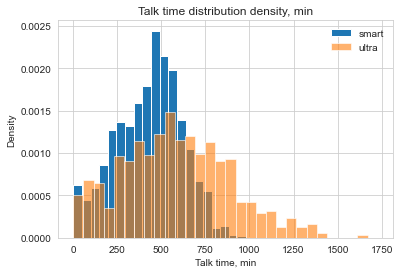

In [31]:
all_data[all_data['tariff'] == 'smart']['duration'].hist(bins=30, density=True, label='smart')
all_data[all_data['tariff'] == 'ultra']['duration'].hist(bins=30, density=True, alpha=0.6, label='ultra')

plt.title('Talk time distribution density, min')
plt.xlabel('Talk time, min')
plt.ylabel('Density')
plt.legend(loc="upper right", frameon=False)

plt.show()

<div style="background-color: #F2E0C9">

- For the *Smart* tariff, the distribution is normal with a maximum of around 500 minutes. It is important to note that many users spend minutes over the tariff limit (500 min)
- For the *Ultra* tariff, the distribution is smoother, there is no obvious peak. Compared to Smart, more people spend up to 250 minutes and more than 750 minutes.

</div>

 ### Analysis of the number of messages

In [32]:
messages_smart = stat_tarif('messages', 'smart')

Tarif "smart":
Average: 39.0
Mediana: 35.0
Dispersion: 661.0
Standard deviation: 26.0


In [33]:
messages_ultra = stat_tarif('messages', 'ultra')

Tarif "ultra":
Average: 57.0
Mediana: 49.0
Dispersion: 1818.0
Standard deviation: 43.0


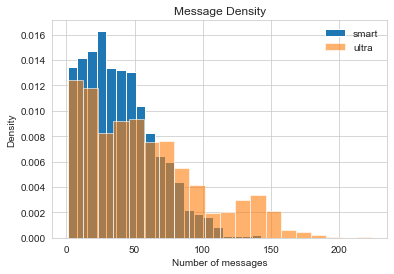

In [34]:
all_data[all_data['tariff'] == 'smart']['messages'].hist(bins=20, density=True, label='smart')
all_data[all_data['tariff'] == 'ultra']['messages'].hist(bins=20, density=True, alpha=0.6, label='ultra')

plt.title('Message Density')
plt.xlabel('Number of messages')
plt.ylabel('Density')
plt.legend(loc="upper right", frameon=False)

plt.show()

<div style="background-color: #F2E0C9">

- The data distributions are close to the Poisson distribution.
- Users of the *Smart* tariff send an average of 39 sms, which does not exceed the limit of 50. Although there are users who send more than 100.
- Users of the *Ultra* tariff send an average of 62 messages. In general, more users send a large number of SMS per month.

</div>

### Internet usage analysis

In [35]:
internet_smart = stat_tarif('mb', 'smart')

Tarif "smart":
Average: 16034.0
Mediana: 16296.0
Dispersion: 30461581.0
Standard deviation: 5519.0


In [36]:
internet_ultra = stat_tarif('mb', 'ultra')

Tarif "ultra":
Average: 19729.0
Mediana: 19461.0
Dispersion: 86148373.0
Standard deviation: 9282.0


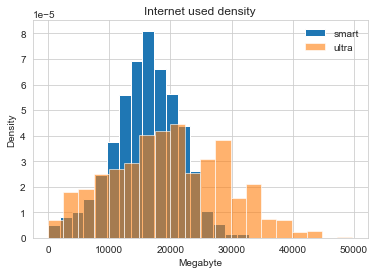

In [37]:
all_data[all_data['tariff'] == 'smart']['mb'].hist(bins=20, density=True, label='smart')
all_data[all_data['tariff'] == 'ultra']['mb'].hist(bins=20, density=True, alpha=0.6, label='ultra')

plt.title('Internet used density')
plt.xlabel('Megabyte')
plt.ylabel('Density')
plt.legend(loc="upper right", frameon=False)

plt.show()

<div style="background-color: #F2E0C9">

- Distribution for both types of tariffs is normal. Both there and there there is a small part of users who do not use the Internet at all.
- Users of the *Smart* tariff spend an average of 16 GB, which is slightly more than the established limit. At the same time, half of the users spend more than the limit.
- Users of the *Ultra* tariff spend an average of 19 GB. There is no clear peak in the distribution. Users in general use more internet. There is a small peak at the 30 GB limit.

</div>

### Analysis of user spending within the tariff

In [38]:
smart = all_data[all_data['tariff'] == 'smart'].groupby(['user_id']).agg(
    {'revenue': 'mean',
     'duration': 'mean',
     'messages': 'mean',
     'mb': 'mean'})
smart

,revenue,duration,messages,mb
user_id,,,,
1001,950.000000,437.000000,NaN,16240.000000
1002,1035.714286,223.000000,10.0,16586.931429
1005,862.000000,564.333333,46.0,8310.442500
1006,931.818182,326.818182,NaN,14935.346364
1007,932.777778,501.111111,25.0,14634.407778
...,...,...,...,...
1494,996.000000,398.600000,NaN,15404.832000
1496,2392.833333,512.083333,39.0,22590.274167
1497,947.333333,483.666667,17.0,15196.990000


In [39]:
print('Number of users with subscription fee only:', len(smart[smart['revenue'] == 550]))
print('Percentage of users exceeding the limit by minutes:', round((len(smart[smart['duration']  > 500]) / 301), 2))
print('Percentage of users exceeding the SMS limit:', round((len(smart[smart['messages']  > 50]) / 301), 2))
print('Percentage of users exceeding the GB limit:', round((len(smart[smart['mb']  > 15375]) / 301), 2))
print('Total revenue from the tariff per month:', np.ceil(smart['revenue'].sum()))

Number of users with subscription fee only: 17
Percentage of users exceeding the limit by minutes: 0.37
Percentage of users exceeding the SMS limit: 0.27
Percentage of users exceeding the GB limit: 0.71
Total revenue from the tariff per month: 470529.0


In [40]:
ultra = all_data[all_data['tariff'] == 'ultra'].groupby(['user_id']).agg(
    {'revenue': 'mean',
     'duration': 'mean',
     'messages': 'mean',
     'mb': 'mean'})
ultra

,revenue,duration,messages,mb
user_id,,,,
1000,1950.0,330.125000,62.000,13425.788750
1003,1950.0,782.800000,76.000,11456.528000
1004,1950.0,128.000000,149.000,18632.685000
1013,1950.0,486.000000,21.000,15261.580000
1016,1950.0,64.000000,71.000,13405.720000
...,...,...,...,...
1476,1950.0,536.375000,5.625,16699.990000
1485,1950.0,606.000000,155.000,23425.760000
1491,1950.0,526.888889,48.000,17942.137778


In [41]:
print('Number of users with subscription fee only:', len(ultra[ultra['revenue'] == 1950]))
print('Percentage of users exceeding the limit by minutes:', round((len(ultra[ultra['duration']  > 3000]) / 118), 2))
print('Percentage of users exceeding the SMS limit:', round((len(ultra[ultra['messages']  > 1000]) / 118), 2))
print('Percentage of users exceeding the GB limit:', round((len(ultra[ultra['mb']  > 30750]) / 118), 2))
print('Total revenue from the tariff per month:', np.ceil(ultra['revenue'].sum()))

Number of users with subscription fee only: 105
Percentage of users exceeding the limit by minutes: 0.0
Percentage of users exceeding the SMS limit: 0.0
Percentage of users exceeding the GB limit: 0.14
Total revenue from the tariff per month: 308814.0


<div style="background-color: #F2E0C9">

- Among the users of both tariffs there are those who exceed the limits for minutes, messages and GB.
- For *Smart* explicit peaks are highlighted on the values corresponding to the limits. This says that users keep track of how much they spend. The more expensive *Ultra* tariff is characterized by a smoother distribution, without obvious peaks.
- The total revenue of the *Smart* tariff is higher.
- Basically, users spend more for the Internet.

</div>

## Hypothesis testing

### Hypothesis about the revenue of two tariffs

*H0:* the average revenue of users of the Ultra and Smart tariffs do not differ

*H1:* The average revenue of Ultra and Smart users is different

In [42]:
smart_revenue = all_data[all_data['tariff'] == 'smart']['revenue']
ultra_revenue = all_data[all_data['tariff'] == 'ultra']['revenue']
alpha = .05

results = st.ttest_ind(
    smart_revenue,
    ultra_revenue)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.0
Rejecting the null hypothesis


In [43]:
print('Average revenue from "Smart" users:', np.ceil(smart_revenue.mean()))
print('Average revenue from "Ultra" users:', np.ceil(ultra_revenue.mean()))

Average revenue from "Smart" users: 1254.0
Average revenue from "Ultra" users: 2036.0


<div style="background-color: #F2E0C9">

 **Resume**

- Based on testing hypotheses, we can say that the average revenue from tariff users is different.
- Users of the *Smart* tariff pay almost twice as much as the cost of the tariff itself. This means that they often go beyond the limits of the tariff.
- Users of the *Ultra* tariff, on average, pay almost only the subscription fee for the tariff. However, this is still more than the revenue from the *Smart* tariff.

</div>

### Hypothesis about revenue from users in different regions

*H0*: The average revenue of users from Moscow does not differ from the revenue of users from other regions.

*H1*: The average revenue of users from Moscow differs from the revenue of users from other regions.

In [44]:
moscow_revenue = all_data[all_data['city'] == 'Москва']['revenue']
region_revenue = all_data[all_data['city'] != 'Москва']['revenue']
alpha = .05

results = st.ttest_ind(
    moscow_revenue,
    region_revenue
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 9.032872630444846e-158
Rejecting the null hypothesis


In [45]:
print('Average revenue from users in Moscow:', np.ceil(moscow_revenue.mean()))
print('Average revenue from users from other regions:', np.ceil(region_revenue.mean()))

Average revenue from users in Moscow: 1563.0
Average revenue from users from other regions: 1450.0


<div style="background-color: #F2E0C9">

**Resume**

- We cannot disprove the null hypothesis: the average revenue of users from Moscow does not differ from the revenue of users from other regions.
- The average revenue from users from Moscow and other regions is practically the same (approximately 1500-1600 rubles per month)

</div>


## Conclusions

- More users are connected to the tariff *Smart*
- Total profit per month comes from *Smart* tariff
- Basically, users pay extra for the Internet, regardless of the tariff
- Users of the *Ultra* tariff practically do not exceed the limits, except for megabytes of the Internet.
- Despite the fact that *Smart* brings more profit, the average revenue is higher for *Ultra*.
- The difference in average revenue from Moscow and other regions is insignificant.

**For promotion, you should pay attention to the tariff *Ultra*. In the future, users will be able to bring more profit. Since users don't go beyond their minute and message limits, you can suggest that they change them to GB when they get close to the threshold.
  *Smart* users who often exceed tariff limits can advertise *Ultra* tariff**
